In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        #return np.exp(x)/(np.sum(np.exp(x),axis=1)[:,None])
        return (np.exp(x)/(np.sum(np.exp(x))))
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return (a * (1 - a))
    
    def __ReLU(self,x):
        return np.vectorize(lambda x:x if x>0 else 0)(x)
    
    def __ReLU_deriv(self,a):
        #a = ReLU()
        return np.vectorize(lambda x:1 if x>0 else 0)(a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if (mode=='train' and self.dropout>0):
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=input.shape)/(1-self.dropout)
            lin_output = np.dot(self.dropout_vector*input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        self.grad_W = (np.atleast_2d(self.dropout_vector*self.input if self.dropout>0 else self.input).T.dot(np.atleast_2d(delta)))
        self.grad_b = delta
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        self.mode = 'train'
    
    def test(self):
        self.mode = 'test'

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y*np.log(y_hat)
        loss = -np.sum(error)
        delta = (y_hat-y)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.train()
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                else:
                    loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        self.test()
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output
    
    def optimize(self, X, y, learning_rate=0.01, test_size=0.25, epochs=10, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        losses = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        
        for e in range(epochs):
            loss=np.zeros(X_train.shape[0])         
            
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            
            # Calculate train and Test Accuracy
            accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
            accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
            
            self.train()
            for it in range(X_train.shape[0]):
                i=np.random.randint(X_train.shape[0])
                
                
                # forward pass
                y_hat = self.forward(X_train[i])

                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta = self.criterion_CELoss(y_train[i],y_hat)
                else:
                    loss[it],delta = self.criterion_MSE(y_train[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
                
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            accuracies_val.append(accuracy_train)
            accuracies_test.append(accuracy_val)
            
            if verbose:
                print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                      format(e, accuracy_train, accuracy_val, np.mean(loss)))
            
            losses[e] = np.mean(loss)
        return losses, accuracies_val, accuracies_test

Epoch: 0..
train Accuracy: 0.10246666666666666 
Validation Accuracy: 0.1174 
Loss: 0.6678961952755198 

Epoch: 1..
train Accuracy: 0.8626888888888888 
Validation Accuracy: 0.8458 
Loss: 0.34707613960717637 

Epoch: 2..
train Accuracy: 0.8796888888888889 
Validation Accuracy: 0.8606666666666667 
Loss: 0.2965338498545959 

Epoch: 3..
train Accuracy: 0.8864666666666666 
Validation Accuracy: 0.8628666666666667 
Loss: 0.26903911945330916 

Epoch: 4..
train Accuracy: 0.9069111111111111 
Validation Accuracy: 0.8658 
Loss: 0.24612234831952046 



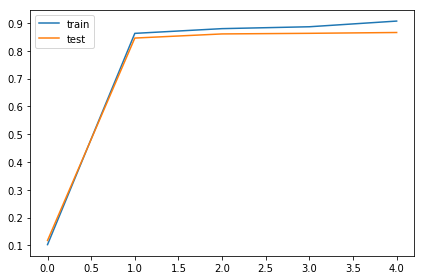

In [39]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,512,128,32,10],activation=[None, 'ReLU', 'ReLU', 'ReLU', 'softmax'], dropout=[0, 0, 0, 0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.01,epochs=5)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

In [ ]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.02,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

Epoch: 0..
train Accuracy: 0.10271111111111111 
Validation Accuracy: 0.0982 
Loss: 0.6172979665369405 

Epoch: 1..
train Accuracy: 0.8249111111111112 
Validation Accuracy: 0.8136666666666666 
Loss: 0.5552553613926874 

Epoch: 2..
train Accuracy: 0.8004666666666667 
Validation Accuracy: 0.7898666666666667 
Loss: 0.5357286066458394 

Epoch: 3..
train Accuracy: 0.8010222222222222 
Validation Accuracy: 0.7884 
Loss: 0.5676060786778625 

Epoch: 4..
train Accuracy: 0.8335555555555556 
Validation Accuracy: 0.8195333333333333 
Loss: 0.5942903682121251 

Epoch: 5..
train Accuracy: 0.7999111111111111 
Validation Accuracy: 0.7872666666666667 
Loss: 0.6980279904846414 

Epoch: 6..
train Accuracy: 0.7865111111111112 
Validation Accuracy: 0.7770666666666667 
Loss: 0.7687783121083894 



C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in multiply
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\numpy\lib\function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Epoch: 7..
train Accuracy: 0.7671555555555556 
Validation Accuracy: 0.7549333333333333 
Loss: nan 

Epoch: 8..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 

Epoch: 9..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 

Epoch: 10..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 

Epoch: 11..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 

Epoch: 12..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 

Epoch: 13..
train Accuracy: 0.1005111111111111 
Validation Accuracy: 0.09846666666666666 
Loss: nan 



Epoch: 0..
train Accuracy: 0.09186666666666667 
Validation Accuracy: 0.0924 
Loss: 0.5747337126131791 

Epoch: 1..
train Accuracy: 0.8689333333333333 
Validation Accuracy: 0.8530666666666666 
Loss: 0.35969866675387197 

Epoch: 2..
train Accuracy: 0.8882444444444444 
Validation Accuracy: 0.8606 
Loss: 0.30341518716479865 

Epoch: 3..
train Accuracy: 0.8869333333333334 
Validation Accuracy: 0.8546 
Loss: 0.2663255349647149 

Epoch: 4..
train Accuracy: 0.9083333333333333 
Validation Accuracy: 0.8617333333333334 
Loss: 0.2301958636671403 

Epoch: 5..
train Accuracy: 0.9219111111111111 
Validation Accuracy: 0.8752 
Loss: 0.204880097996454 

Epoch: 6..
train Accuracy: 0.9340444444444445 
Validation Accuracy: 0.8746 
Loss: 0.1739117841552265 

Epoch: 7..
train Accuracy: 0.9474222222222223 
Validation Accuracy: 0.8782 
Loss: 0.1545787193916106 

Epoch: 8..
train Accuracy: 0.9447111111111111 
Validation Accuracy: 0.8766666666666667 
Loss: 0.14221420523419143 

Epoch: 9..
train Accuracy: 0.96095

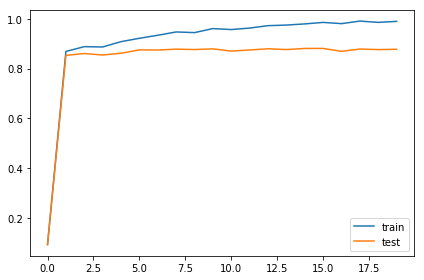

In [6]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,512,128,32,10],activation=[None, 'logistic', 'logistic', 'logistic', 'softmax'], dropout=[0.0, 0.0, 0.0, 0.0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.02,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

In [7]:
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers, metrics, Sequential

import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

y = label
X = data

y_dummies = np.array(pd.get_dummies(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=0.25, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [8]:
import tensorflow
import tensorflow as tf
import keras
config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tensorflow.Session(config=config) 
keras.backend.set_session(sess)

In [48]:
with tf.device('GPU'):
    sgd = optimizers.adadelta()
    model = Sequential()
    model.add(Dense(128))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
    model.fit(X_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
45000/45000 [==============================] - 2s 44us/step - loss: 1.0044 - acc: 0.6607 - categorical_accuracy: 0.6607
Epoch 2/20
45000/45000 [==============================] - 1s 32us/step - loss: 0.5680 - acc: 0.8101 - categorical_accuracy: 0.8101
Epoch 3/20
45000/45000 [==============================] - 1s 31us/step - loss: 0.5141 - acc: 0.8248 - categorical_accuracy: 0.8248
Epoch 4/20
45000/45000 [==============================] - 1s 31us/step - loss: 0.4767 - acc: 0.8391 - categorical_accuracy: 0.8391
Epoch 5/20
45000/45000 [==============================] - 1s 32us/step - loss: 0.4545 - acc: 0.8451 - categorical_accuracy: 0.8451
Epoch 6/20
45000/45000 [==============================] - 1s 32us/step - loss: 0.4328 - acc: 0.8497 - categorical_accuracy: 0.8497
Epoch 7/20
45000/45000 [==============================] - 1s 33us/step - loss: 0.4221 - acc: 0.8567 - categorical_accuracy: 0.8567
Epoch 8/20
45000/45000 [==============================] - 1s 32us/step - loss: 0.40

In [49]:
yhat_val = model.predict(X_val)

In [50]:
accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

In [51]:
accuracy_val

0.8908666666666667

In [13]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
#from torch import cuda
#assert cuda.is_available()
#assert cuda.device_count() > 0
#print(cuda.get_device_name(cuda.current_device()))